# 1次元の畳み込みニューラルネットワークスクラッチ

畳み込みニューラルネットワーク（CNN） のクラスをスクラッチで作成していきます。NumPyなど最低限のライブラリのみを使いアルゴリズムを実装していきます。


このSprintでは1次元の 畳み込み層 を作成し、畳み込みの基礎を理解することを目指します。次のSprintでは2次元畳み込み層とプーリング層を作成することで、一般的に画像に対して利用されるCNNを完成させます。


クラスの名前はScratch1dCNNClassifierとしてください。クラスの構造などは前のSprintで作成したScratchDeepNeuralNetrowkClassifierを参考にしてください。

## 1次元畳み込み層とは
CNNでは画像に対しての2次元畳み込み層が定番ですが、ここでは理解しやすくするためにまずは1次元畳み込み層を実装します。1次元畳み込みは実用上は自然言語や波形データなどの 系列データ で使われることが多いです。


畳み込みは任意の次元に対して考えることができ、立体データに対しての3次元畳み込みまではフレームワークで一般的に用意されています。


## データセットの用意
検証には引き続きMNISTデータセットを使用します。1次元畳み込みでは全結合のニューラルネットワークと同様に平滑化されたものを入力します。

In [603]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

%matplotlib inline

#### まず適当なテストデータを作る
1dCNNは多くの場合で時系列解析に用いられます。そのため、テストデータは簡単な異常検知モデルにしてみましょう。

※本来、時系列の異常検知システムは逐次的に見ることが多いので、本当はこんな風にバッチごとに見るようなことは少ないです。

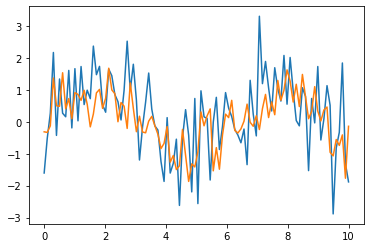

In [604]:
data_length = 100
n_sample = 100000
anomaly_noise = np.random.randn(data_length)    #異常値は分散が大きい
nomaly_noise  = np.random.randn(data_length)/2  #正常値は分散が小さい

#時系列とラベルを生成
t = np.linspace(0,10,data_length)
x_anomaly = np.array([np.sin(t) + anomaly_noise for i in range(n_sample//2)])
x_nomaly  = np.array([np.sin(t) + nomaly_noise  for i in range(n_sample//2)])
X = np.concatenate([x_anomaly,x_nomaly])
y = np.concatenate([np.ones(n_sample//2),np.zeros(n_sample//2)])

#シャッフル
rand_idx = np.arange(n_sample)
np.random.shuffle(rand_idx)
X = X[rand_idx,:]
y = y[rand_idx]

#描画
plt.plot(t,x_anomaly[0,:])
plt.plot(t,x_nomaly[0,:])
plt.show()

In [605]:
#データ分割

from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y)

In [606]:
#one-hot化

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)

y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])

## 【問題1】チャンネル数を1に限定した1次元畳み込み層クラスの作成
チャンネル数を1に限定した1次元畳み込み層のクラスSimpleConv1dを作成してください。基本構造は前のSprintで作成した全結合層のFCクラスと同じになります。なお、重みの初期化に関するクラスは必要に応じて作り変えてください。Xavierの初期値などを使う点は全結合層と同様です。


ここでは パディング は考えず、ストライド も1に固定します。また、複数のデータを同時に処理することも考えなくて良く、バッチサイズは1のみに対応してください。この部分の拡張はアドバンス課題とします。


フォワードプロパゲーションの数式は以下のようになります。

$$
a_i = \sum_{s=0}^{F-1}x_{(i+s)}w_s+b
$$

ai: 出力される配列のi番目の値


F: フィルタのサイズ


x(i+s): 入力の配列の(i+s)番目の値


ws: 重みの配列のs番目の値


b: バイアス項


全てスカラーです。


次に更新式です。ここがAdaGradなどに置き換えられる点は全結合層と同様です。

$$
w_s^{\prime} = w_s - \alpha \frac{\partial L}{\partial w_s} \\
b^{\prime} = b - \alpha \frac{\partial L}{\partial b}
$$

α: 学習率

$\frac{\partial L}{\partial w_s}$: wsに関する損失Lの勾配

$\frac{\partial L}{\partial b}$: bに関する損失Lの勾配

勾配$\frac{\partial L}{\partial w_s}$や$\frac{\partial L}{\partial b}$を求めるためのバックプロパゲーションの数式が以下です。

$$
\frac{\partial L}{\partial w_s} = \sum_{i=0}^{N_{out}-1} \frac{\partial L}{\partial a_i}x_{(i+s)}\\
\frac{\partial L}{\partial b} = \sum_{i=0}^{N_{out}-1} \frac{\partial L}{\partial a_i}
$$

$\frac{\partial L}{\partial a_i}$: 勾配の配列のi番目の値

Nout: 出力のサイズ

前の層に流す誤差の数式は以下です。

$$
\frac{\partial L}{\partial x_j} = \sum_{s=0}^{F-1} \frac{\partial L}{\partial a_{(j-s)}}w_s
$$

$\frac{\partial L}{\partial x_j}$: 前の層に流す誤差の配列のj番目の値

ただし、j−s < 0またはj−s > Nout−1のとき$\frac{\partial L}{\partial a_{(j-s)}} =0$です。

全結合層との大きな違いは、重みが複数の特徴量に対して共有されていることです。この場合は共有されている分の誤差を全て足すことで勾配を求めます。計算グラフ上での分岐はバックプロパゲーションの際に誤差の足し算をすれば良いことになります。


In [110]:
x = np.array([1, 2, 3, 4])
w = np.array([3, 5, 7])

res = []
for i in range(x.shape[0] - w.shape[0] + 1):
    res.append(np.sum(x[i:i+w.shape[0]] * w))
    
res = np.array(res)
res

array([34, 49])

In [111]:
class SimpleConv1d:
    """

    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, w, b, optimizer):
        #最適化手法(SGD, AdaGrad)を引数で受け取りインスタンス化
        self.optimizer = optimizer
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
#         self.w = initializer.W(n_nodes1)
#         self.b = initializer.B(n_nodes2)
        self.w = w
        self.b = b
        ##層の各ノードの偏微分係数をインスタンスで保持
        self.X = None      
        self.dA = None
        self.dw = None
        self.dx = None
        
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """     
        #インスタンスに保存(backwardで使用)
        self.X = X.copy()
        #層の総入力
        
        res = []
        #ストライドは1に固定
        for i in range(X.shape[0] - self.w.shape[0] + 1):
            res.append(np.sum(X[i:i+self.w.shape[0]] * self.w) + self.b)

        A = np.array(res).flatten()
        
        return A
    
    def backward(self, y, A):
        """
        バックワード
        Parameters
        ----------
        y : 
            正解ラベル
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        #インスタンスに保存(パラメータ更新で使用)
        #後ろから流れてきた勾配はloss(正解ラベルyと出力Aの差)<-softmax
        self.dA = y - A
        
        #初期化
        self.dx = np.zeros(self.X.shape[0])
        self.dw = np.zeros(self.w.shape[0])
        
        #dAを1つずつwとdxに伝播
        #dxの最初からwの数ずつストライドさせながら伝播
        idx = np.arange(self.w.shape[0])    
        for i in range(self.dA.shape[0]):
            #dxの中に足し合わせていく
            self.dx[idx] += self.dA[i] * self.w
            idx += 1
        
        # self.w, self.bの更新
        self = self.optimizer.update(self)
        return self.dx

In [639]:
class SGD_Conv1d:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
        
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
    
        """
        
        #dAを1つずつxとdwに伝播
        #xの最初からwの数ずつストライドさせながら伝播
        idx = np.arange(layer.w.shape[0])    
        for i in range(layer.dA.shape[0]):
            #dwの中に足し合わせていく
            layer.dw += layer.dA[i] * layer.X[idx]
            idx += 1
            
        #偏微分係数を元に重みとバイアスを更新 
        layer.w -= self.lr * layer.dw
        layer.db = np.sum(layer.dA, axis=0)

        layer.b -= self.lr * layer.db
    
        return layer

In [113]:
class SimpleInitializer:
    """
    ガウス分布によるシンプルな初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    def __init__(self, sigma):
        self.sigma = sigma
        
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W :
        """
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B :
        """
        B = self.sigma * np.random.randn(n_nodes2)
        return B

## 【問題2】1次元畳み込み後の出力サイズの計算
畳み込みを行うと特徴量の数が変化します。どのように変化するかは以下の数式から求められます。パディングやストライドも含めています。この計算を行う関数を作成してください。

$$
N_{out} =  \frac{N_{in}+2P-F}{S} + 1\\
$$

Nout: 出力のサイズ（特徴量の数）

Nin: 入力のサイズ（特徴量の数）

P: ある方向へのパディングの数

F: フィルタのサイズ

S: ストライドのサイズ


In [114]:
def calc_out_shape(n_in, p, f, s):
    n_out = ((n_in + 2*p - f) / s) + 1
    return n_out

## 【問題3】小さな配列での1次元畳み込み層の実験
次に示す小さな配列でフォワードプロパゲーションとバックプロパゲーションが正しく行えているか確認してください。


入力x、重みw、バイアスbを次のようにします。

In [115]:
x = np.array([1,2,3,4])
w = np.array([3, 5, 7])
b = np.array([1])

フォワードプロパゲーションをすると出力は次のようになります。

In [116]:
a = np.array([35, 50])

#### クラス化せずにとりあえず試す

In [117]:
x = np.array([1, 2, 3, 4])
w = np.array([3, 5, 7])
b = np.array([1])

res = []
for i in range(x.shape[0] - w.shape[0] + 1):
    res.append(np.sum(x[i:i+w.shape[0]] * w) + b)
    
res = np.array(res).flatten()
res

array([35, 50])

In [118]:
x = np.array([1, 2, 3, 4])
w = np.array([3, 5, 7])
b = np.array([1])

res = np.array([])
for i in range(x.shape[0] - w.shape[0] + 1):
    res = np.append(res, np.sum(x[i:i+w.shape[0]] * w) + b)

res

array([35., 50.])

#### 実装したクラスを試す

In [119]:
x = np.array([1., 2., 3., 4.])
w = np.array([3., 5., 7.])
b = np.array([1.])
optimizer = SGD(0.01)
sc1d = SimpleConv1d(w, b, optimizer)
A = sc1d.forward(x)
A

array([35., 50.])

次にバックプロパゲーションを考えます。誤差は次のようであったとします。

In [120]:
delta_a = np.array([10., 20.])

バックプロパゲーションをすると次のような値になります。

In [121]:
delta_b = np.array([30])
delta_w = np.array([50, 80, 110])
delta_x = np.array([30, 110, 170, 140])

In [122]:
#正解ラベルを用意
y = [45., 70.]

dx = sc1d.backward(y, A)
print('db', sc1d.db)
print('dw', sc1d.dw)
print('dx', dx)

db 30.0
dw [ 50.  80. 110.]
dx [ 30. 110. 170. 140.]


##  実装上の工夫
畳み込みを実装する場合は、まずはfor文を重ねていく形で構いません。しかし、できるだけ計算は効率化させたいため、以下の式を一度に計算する方法を考えることにします。

$$
a_i = \sum_{s=0}^{F-1}x_{(i+s)}w_s+b
$$

バイアス項は単純な足し算のため、重みの部分を見ます。

$$
\sum_{s=0}^{F-1}x_{(i+s)}w_s
$$

これは、xの一部を取り出した配列とwの配列の内積です。具体的な状況を考えると、以下のようなコードで計算できます。この例では流れを分かりやすくするために、各要素同士でアダマール積を計算してから合計を計算しています。これは結果的に内積と同様です。


In [130]:
x = np.array([1, 2, 3, 4])
w = np.array([3, 5, 7])
a = np.empty((2, 3))
indexes0 = np.array([0, 1, 2]).astype(np.int)
indexes1 = np.array([1, 2, 3]).astype(np.int)
a[0] = x[indexes0]*w # x[indexes0]は([1, 2, 3])である
a[1] = x[indexes1]*w # x[indexes1]は([2, 3, 4])である
a = a.sum(axis=1)
a

array([34., 49.])

In [133]:
#内積を使って書き換え

a[0] = np.dot(x[indexes0], w.T)
a[1] = np.dot(x[indexes1], w.T)
a

array([34., 49.])

ndarrayは配列を使ったインデックス指定ができることを利用した方法です。


また、二次元配列を使えば一次元配列から二次元配列が取り出せます。

In [126]:
x = np.array([1, 2, 3, 4])
indexes = np.array([[0, 1, 2], [1, 2, 3]]).astype(np.int)
print(x[indexes]) # ([[1, 2, 3], [2, 3, 4]])

[[1 2 3]
 [2 3 4]]


このこととブロードキャストなどをうまく組み合わせることで、一度にまとめて計算することも可能です。

畳み込みの計算方法に正解はないので、自分なりに効率化していってください。

《参考》 
以下のページのInteger array indexingの部分がこの方法についての記述です。

Indexing — NumPy v1.17 Manual

## 【問題4】チャンネル数を限定しない1次元畳み込み層クラスの作成
チャンネル数を1に限定しない1次元畳み込み層のクラスConv1dを作成してください。


例えば以下のようなx, w, bがあった場合は、

In [593]:
x = np.array([[1, 2, 3, 4], [2, 3, 4, 5]]) # shape(2, 4)で、（入力チャンネル数、特徴量数）である。
w = np.ones((3, 2, 3)) # 例の簡略化のため全て1とする。(出力チャンネル数、入力チャンネル数、フィルタサイズ)である。
b = np.array([1, 2, 3]) # （出力チャンネル数）

出力は次のようになります。

In [594]:
a = np.array([[16, 22], [17, 23], [18, 24]]) # shape(3, 2)で、（出力チャンネル数、特徴量数）である。

入力が2チャンネル、出力が3チャンネルの例です。計算グラフを書いた上で、バックプロパゲーションも手計算で考えてみましょう。計算グラフの中には和と積しか登場しないので、微分を新たに考える必要はありません。

《補足》

チャンネル数を加える場合、配列をどういう順番にするかという問題があります。(バッチサイズ、チャンネル数、特徴量数)または(バッチサイズ、特徴量数、チャンネル数)が一般的で、ライブラリによって順番は異なっています。（切り替えて使用できるものもあります）

今回のスクラッチでは自身の実装上どちらが効率的かを考えて選んでください。上記の例ではバッチサイズは考えておらず、(チャンネル数、特徴量数)です。

In [578]:
#(バッチサイズ、チャンネル数、特徴量数(h(今回は1次元なのでなし),w))
#出力データのチャンネル数はフィルターの個数になる

x = np.array([[1, 2, 3, 4], [2, 3, 4, 5]]) # shape(2, 4)で、（入力チャンネル数、特徴量数）である。
w = np.ones((3, 2, 3)) # 例の簡略化のため全て1とする。(出力チャンネル数、入力チャンネル数、フィルタサイズ)である。
b = np.array([1, 2, 3]) # （出力チャンネル数）

#二次元配列でインデックス指定のマスクを用意
indexes1 = np.array([[0, 1, 2], [1, 2, 3]]).astype(np.int)

In [579]:
#xからch1の前半3つ後半3つ、ch2の前半3つ後半3つ
x_all = x[:, indexes1]
x_all

array([[[1, 2, 3],
        [2, 3, 4]],

       [[2, 3, 4],
        [3, 4, 5]]])

forwardの実装  
とりあえずch1の計算のみ作ってみてイメージをつかむ

In [580]:
#ch1を取り出す
x_ch1 = x_all[0] #array([[1, 2, 3],[2, 3, 4]])
#全フィルタからch1を取り出す
w_ch1 = w[:, 0] #array([[1., 1., 1.], [1., 1., 1.], [1., 1., 1.]])
#出力前の足し合わせ前
x_w_ch1 = np.dot(x_ch1, w_ch1.T) #array([[6., 6., 6.], [9., 9., 9.]])
#出力1列目のch1, ch2, ch3
out_1 = np.sum(x_w_ch1, axis=0) #array([15., 15., 15.])
#バイアスを足した出力1列目のch1, ch2, ch3
final_out1 = out_1 + b
final_out1

array([16., 17., 18.])

上を参考にチャンネル数を限定しないパターンを作る

In [581]:
#インデックス指定のマスクを用意
idx = []
#ストライド1, パディング0の場合
for i in range(x.shape[-1] - w.shape[-1] + 1):
    idx.append(np.arange(w.shape[0]) + i)
idx = np.array(idx) #array([[0, 1, 2], [1, 2, 3]])

#xからch1の前半3つ後半3つ、ch2の前半3つ後半3つ
x_all = x[:, idx] #array([[[1, 2, 3],[2, 3, 4]],[[2, 3, 4],[3, 4, 5]]])

res = []
#チャンネル数だけfor文で回す
for i in range(x.shape[0]):
    #ch1を取り出す
    x_ch1 = x_all[i] #array([[1, 2, 3],[2, 3, 4]])
    #全フィルタからch1を取り出す
    w_ch1 = w[:, i] #array([[1., 1., 1.], [1., 1., 1.], [1., 1., 1.]])
    #出力前の足し合わせ前
    x_w_ch1 = np.dot(x_ch1, w_ch1.T) #array([[6., 6., 6.], [9., 9., 9.]])
    #出力1列目のch1, ch2, ch3
    out_1 = np.sum(x_w_ch1, axis=0) #array([15., 15., 15.])
    #バイアスを足した出力1列目のch1, ch2, ch3
    final_out1 = out_1 + b
    res.append(final_out1)
    
res = np.array(res).T
res

array([[16., 22.],
       [17., 23.],
       [18., 24.]])

backwardの実装(dx)

In [582]:
x = np.array([[1., 2., 3., 4.], [2., 3., 4., 5.]]) # shape(2, 4)で、（入力チャンネル数、特徴量数）である。
w = np.ones((3, 2, 3)) # 例の簡略化のため全て1とする。(出力チャンネル数、入力チャンネル数、フィルタサイズ)である。
b = np.array([1., 2., 3.]) # （出力チャンネル数）

In [583]:
#正解ラベルを用意
y = np.array([[17., 24.], [20., 27.], [23., 30.]])

In [584]:
dA = y - res #array([[1., 2.],[3., 4.],[5., 6.]])

In [585]:
#dAのch1,ch2,ch3の0列目
dA0 = dA[:, 0] #array([1., 3., 5.])
#wのf1,f2,f3のch1
w_ch1 = w[:, 0] #array([[1., 1., 1.], [1., 1., 1.], [1., 1., 1.]])
dA0 * w_ch1

array([[1., 3., 5.],
       [1., 3., 5.],
       [1., 3., 5.]])

In [586]:
dA_ch1_0 = np.sum(dA0 * w_ch1, axis=1).T
dA_ch1_0

array([9., 9., 9.])

In [587]:
#dAのch1,ch2,ch3の1列目
dA1 = dA[:, 1] #array([1., 3., 5.])
#wのf1,f2,f3のch1
w_ch1 = w[:, 0] #array([[1., 1., 1.], [1., 1., 1.], [1., 1., 1.]])
dA1 * w_ch1

array([[2., 4., 6.],
       [2., 4., 6.],
       [2., 4., 6.]])

In [588]:
dA_ch1_1 = np.sum(dA1 * w_ch1, axis=1).T
dA_ch1_1

array([12., 12., 12.])

In [589]:
#dxの初期化
dx = np.zeros(x.shape) #array([[0., 0., 0., 0.],[0., 0., 0., 0.]])
#dxのch1の前半3つ
dx[0, [0, 1, 2]] += dA_ch1_0
dx[0, [1, 2, 3]] += dA_ch1_1
dx[0]

array([ 9., 21., 21., 12.])

上を参考にチャンネル数を限定しないパターンを作る

In [590]:
#dxの初期化
dx = np.zeros(x.shape) #array([[0., 0., 0., 0.],[0., 0., 0., 0.]])

dA = y - res #array([[1., 2.],[3., 4.],[5., 6.]])


#dAのch1,ch2,ch3の0列目
dA0 = dA[:, 0] #array([1., 3., 5.])
#wのf1,f2,f3のch1
w_ch1 = w[:, 0] #array([[1., 1., 1.], [1., 1., 1.], [1., 1., 1.]])
dA_ch1_0 = np.sum(dA0 * w_ch1, axis=1).T

#dAのch1,ch2,ch3の1列目
dA1 = dA[:, 1] #array([1., 3., 5.])
#wのf1,f2,f3のch1
w_ch1 = w[:, 0] #array([[1., 1., 1.], [1., 1., 1.], [1., 1., 1.]])
dA_ch1_1 = np.sum(dA1 * w_ch1, axis=1).T


#dxのch1の前半3つ
dx[0, [0, 1, 2]] += dA_ch1_0
dx[0, [1, 2, 3]] += dA_ch1_1


#dAのch1,ch2,ch3の0列目
dA0 = dA[:, 0] #array([1., 3., 5.])
#wのf1,f2,f3のch2
w_ch2 = w[:, 1] #array([[1., 1., 1.], [1., 1., 1.], [1., 1., 1.]])
dA_ch2_0 = np.sum(dA0 * w_ch2, axis=1).T

#dAのch1,ch2,ch3の1列目
dA1 = dA[:, 1] #array([1., 3., 5.])
#wのf1,f2,f3のch2
w_ch2 = w[:, 1] #array([[1., 1., 1.], [1., 1., 1.], [1., 1., 1.]])
dA_ch2_1 = np.sum(dA1 * w_ch2, axis=1).T


#dxのch1の前半3つ
dx[1, [0, 1, 2]] += dA_ch2_0
dx[1, [1, 2, 3]] += dA_ch2_1

dx


array([[ 9., 21., 21., 12.],
       [ 9., 21., 21., 12.]])

In [591]:
#dxの初期化
dx = np.zeros(x.shape) #array([[0., 0., 0., 0.],[0., 0., 0., 0.]])

dA = y - res #array([[1., 2.],[3., 4.],[5., 6.]])

#dxのch数だけ回す
for i in range(dx.shape[0]):
    #wのf1,f2,f3のchi
    w_chi = w[:, i] #array([[1., 1., 1.], [1., 1., 1.], [1., 1., 1.]])
    
    idx = np.arange(w.shape[0])   
    
    dx_i = np.zeros(x.shape[1])
    #dAの列数だけ回す
    for j in range(dA.shape[1]):
        #dAのch1,ch2,ch3のj列目
        dAj = dA[:, j] #array([1., 3., 5.])
        dA_chi_j = np.sum(dAj * w_chi, axis=1).T
        
        dx_i[idx] += dA_chi_j

        idx += 1
    else:
        dx[i] += dx_i       
dx

array([[ 9., 21., 21., 12.],
       [ 9., 21., 21., 12.]])

In [595]:
#xのチャンネル数だけ回す
for j in range(2):
    #フィルタ
    d_idx = np.arange(3)
    #dAのチャンネル数(フィルタの個数)だけ回す
    for s in range(2):
        dx[j, d_idx] += np.sum(dA[:, s]) * w
        d_idx += 1
            
dx

ValueError: non-broadcastable output operand with shape (3,) doesn't match the broadcast shape (3,2,3)

backwardの実装(dw, db)

In [569]:
x = np.array([[1., 2., 3., 4.], [2., 3., 4., 5.]]) # shape(2, 4)で、（入力チャンネル数、特徴量数）である。
w = np.ones((3, 2, 3)) # 例の簡略化のため全て1とする。(出力チャンネル数、入力チャンネル数、フィルタサイズ)である。
b = np.array([1., 2., 3.]) # （出力チャンネル数）
#正解ラベルを用意
y = np.array([[17., 24.], [20., 27.], [23., 30.]])
dA = y - res #array([[1., 2.],[3., 4.],[5., 6.]])

In [538]:
dw = np.zeros(w.shape) 

idx = np.arange(w.shape[0])   

#dwのf1,ch1
dw[0, 0] = dA[0, 0] * x[0, idx] + dA[0, 0] * x[0, idx+1] 
dw

array([[[3., 5., 7.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.]]])

In [539]:
#dwのf2,ch1
dw[1, 0] = dA[1, 0] * x[0, idx] + dA[1, 0] * x[0, idx+1] 
dw

array([[[ 3.,  5.,  7.],
        [ 0.,  0.,  0.]],

       [[ 9., 15., 21.],
        [ 0.,  0.,  0.]],

       [[ 0.,  0.,  0.],
        [ 0.,  0.,  0.]]])

In [540]:
#dwのf3,ch1
dw[2, 0] = dA[2, 0] * x[0, idx] + dA[2, 0] * x[0, idx+1] 
dw

array([[[ 3.,  5.,  7.],
        [ 0.,  0.,  0.]],

       [[ 9., 15., 21.],
        [ 0.,  0.,  0.]],

       [[15., 25., 35.],
        [ 0.,  0.,  0.]]])

In [541]:
#dwのf1,ch2
dw[0, 1] = dA[0, 1] * x[1, idx] + dA[0, 1] * x[1, idx+1] 
dw

array([[[ 3.,  5.,  7.],
        [10., 14., 18.]],

       [[ 9., 15., 21.],
        [ 0.,  0.,  0.]],

       [[15., 25., 35.],
        [ 0.,  0.,  0.]]])

In [542]:
#dwのf2,ch2
dw[1, 1] = dA[1, 1] * x[1, idx] + dA[1, 1] * x[1, idx+1] 
dw

array([[[ 3.,  5.,  7.],
        [10., 14., 18.]],

       [[ 9., 15., 21.],
        [20., 28., 36.]],

       [[15., 25., 35.],
        [ 0.,  0.,  0.]]])

In [543]:
#dwのf3,ch2
dw[2, 1] = dA[2, 1] * x[1, idx] + dA[2, 1] * x[1, idx+1] 
dw

array([[[ 3.,  5.,  7.],
        [10., 14., 18.]],

       [[ 9., 15., 21.],
        [20., 28., 36.]],

       [[15., 25., 35.],
        [30., 42., 54.]]])

In [566]:
#まとめてみる

dw = np.zeros(w.shape) 
idx = np.arange(w.shape[0])

dw[0, 0] += dA[0, 0] * x[0, idx]
dw[1, 0] += dA[1, 0] * x[0, idx]
dw[2, 0] += dA[2, 0] * x[0, idx]

dw[0, 1] += dA[0, 1] * x[1, idx]
dw[1, 1] += dA[1, 1] * x[1, idx]
dw[2, 1] += dA[2, 1] * x[1, idx]


dw[0, 0] += dA[0, 0] * x[0, idx+1] 
dw[1, 0] += dA[1, 0] * x[0, idx+1] 
dw[2, 0] += dA[2, 0] * x[0, idx+1] 

dw[0, 1] += dA[0, 1] * x[1, idx+1] 
dw[1, 1] += dA[1, 1] * x[1, idx+1] 
dw[2, 1] += dA[2, 1] * x[1, idx+1]

dw

array([[[ 3.,  5.,  7.],
        [10., 14., 18.]],

       [[ 9., 15., 21.],
        [20., 28., 36.]],

       [[15., 25., 35.],
        [30., 42., 54.]]])

In [575]:
lr = 0.01

dw = np.zeros(w.shape) 
idx = np.arange(w.shape[0])

#dwのf数だけ回す
for i in range(dw.shape[0]): 
    #dwのch数だけ回す
    for j in range(dw.shape[1]):  
        #dAの列数だけ回す
        for s in range(dA.shape[1]):
            dw[i, j] += dA[i, j] * x[j, idx+s]
 
w -= lr * dw
db = np.sum(dA, axis=1)
b -= lr * db

In [510]:
FN, C, FW = w.shape #3, 2, 3
dw = np.zeros((C, FW))

#ch数回す
for i in range(C):
    i_s_idx = np.arange(FW)     # deltaX計算用index
    #フィルタ数回す
    for s in range(dA.shape[1]):
        dw[i] += np.sum(dA[:, s]) * np.sum(x[i, i_s_idx], axis=0)
        i_s_idx += 1     # 右方向

w -= 0.01 * dw                # 重さ更新

db = np.sum(dA, axis=1)
b -= 0.01 * db                   # バイアス更新

w, b, dw

(array([[[-2.24, -2.24, -2.24],
         [-3.5 , -3.5 , -3.5 ]],
 
        [[-2.24, -2.24, -2.24],
         [-3.5 , -3.5 , -3.5 ]],
 
        [[-2.24, -2.24, -2.24],
         [-3.5 , -3.5 , -3.5 ]]]),
 array([0.94, 1.86, 2.78]),
 array([[162., 162., 162.],
        [225., 225., 225.]]))

In [645]:
class Conv1d:
    """

    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, w, b, optimizer):
        #最適化手法(SGD, AdaGrad)を引数で受け取りインスタンス化
        self.optimizer = optimizer
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
#         self.w = initializer.W(n_nodes1)
#         self.b = initializer.B(n_nodes2)
        self.w = w
        self.b = b
        ##層の各ノードの偏微分係数をインスタンスで保持
        self.X = None      
        self.dA = None
        self.dw = None
        self.dx = None
        
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """     
        #インスタンスに保存(backwardで使用)
        self.x = X.copy()        
        
        #インデックス指定のマスクを用意
        idx = []
        #ストライド1, パディング0の場合
        for i in range(self.x.shape[-1] - self.w.shape[-1] + 1):
            idx.append(np.arange(self.w.shape[0]) + i)
        idx = np.array(idx) #array([[0, 1, 2], [1, 2, 3]])

        #xからch1の前半3つ後半3つ、ch2の前半3つ後半3つ
        x_all = self.x[:, idx] #array([[[1, 2, 3],[2, 3, 4]],[[2, 3, 4],[3, 4, 5]]])

        res = []
        #チャンネル数だけfor文で回す
        for i in range(self.x.shape[0]):
            #ch1を取り出す
            x_ch1 = x_all[i] #array([[1, 2, 3],[2, 3, 4]])
            #全フィルタからch1を取り出す
            w_ch1 = self.w[:, i] #array([[1., 1., 1.], [1., 1., 1.], [1., 1., 1.]])
            #出力前の足し合わせ前
            x_w_ch1 = np.dot(x_ch1, w_ch1.T) #array([[6., 6., 6.], [9., 9., 9.]])
            #出力1列目のch1, ch2, ch3
            out_1 = np.sum(x_w_ch1, axis=0) #array([15., 15., 15.])
            #バイアスを足した出力1列目のch1, ch2, ch3
            final_out1 = out_1 + b
            res.append(final_out1)

        A = np.array(res).T
        
        return A
    
    def backward(self, A):
        """
        バックワード
        Parameters
        ----------
        y : 
            正解ラベル
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        #インスタンスに保存(パラメータ更新で使用)
        #後ろから流れてきた勾配はloss(正解ラベルyと出力Aの差)<-softmax

        #dxの初期化
        self.dx = np.zeros(self.x.shape) 
        self.dw = np.zeros(self.w.shape)

#         self.dA = y - res 
        self.dA = A 

        #dxのch数だけ回す
        for i in range(self.dx.shape[0]):
            #wのf1,f2,f3のchi
            w_chi = self.w[:, i] 
            
            idx = np.arange(self.w.shape[0])   

            dx_i = np.zeros(self.x.shape[1])
            #dAの列数だけ回す
            for j in range(self.dA.shape[1]):

                dAj = self.dA[:, j] 
                dA_chi_j = np.sum(dAj * w_chi, axis=1).T

                dx_i[idx] += dA_chi_j

                idx += 1
            else:
                self.dx[i] += dx_i       
        return self.dx

In [640]:
class SGD_Conv1d:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
        
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
    
        """

        idx = np.arange(layer.w.shape[0])

        #dwのfilter数だけ回す
        for i in range(layer.dw.shape[0]): 
            #dwのch数だけ回す
            for j in range(layer.dw.shape[1]):  
                #dAの列数だけ回す
                for s in range(layer.dA.shape[1]):
                    layer.dw[i, j] += layer.dA[i, j] * layer.x[j, idx+s]

        layer.w -= lr * layer.dw
        layer.db = np.sum(layer.dA, axis=1)
        layer.b -= layer.lr * layer.db
        
        return layer


## 【問題5】（アドバンス課題）パディングの実装
畳み込み層にパディングの機能を加えてください。1次元配列の場合、前後にn個特徴量を増やせるようにしてください。


最も単純なパディングは全て0で埋める ゼロパディング であり、CNNでは一般的です。他に端の値を繰り返す方法などもあります。


フレームワークによっては、元の入力のサイズを保つようにという指定をすることができます。この機能も持たせておくと便利です。なお、NumPyにはパディングの関数が存在します。


numpy.pad — NumPy v1.17 Manual

## 【問題6】（アドバンス課題）ミニバッチへの対応
ここまでの課題はバッチサイズ1で良いとしてきました。しかし、実際は全結合層同様にミニバッチ学習が行われます。Conv1dクラスを複数のデータが同時に計算できるように変更してください。

## 【問題7】（アドバンス課題）任意のストライド数
ストライドは1限定の実装をしてきましたが、任意のストライド数に対応できるようにしてください。

# 検証

## 【問題8】学習と推定
これまで使ってきたニューラルネットワークの全結合層の一部をConv1dに置き換えてMNISTを学習・推定し、Accuracyを計算してください。


出力層だけは全結合層をそのまま使ってください。ただし、チャンネルが複数ある状態では全結合層への入力は行えません。その段階でのチャンネルは1になるようにするか、 平滑化 を行なってください。


画像に対しての1次元畳み込みは実用上は行わないことのため、精度は問いません。

In [599]:
#Full Connected Layer Class
class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        #最適化手法(SGD, AdaGrad)を引数で受け取りインスタンス化
        self.optimizer = optimizer
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.w = initializer.W(n_nodes1, n_nodes2)
        self.b = initializer.B(n_nodes2)
        ##層の各ノードの偏微分係数をインスタンスで保持
        self.bZ = None      
        self.dA = None
        self.hw = 0
        self.hb = 0

        
    def forward(self, bZ):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """     
        #インスタンスに保存(パラメータ更新で使用)
        self.bZ = bZ.copy()
        #層の総入力
        A = np.dot(bZ, self.w) + self.b
        
#         print('self.b', self.b.shape)
#         print('self.w', self.w.shape)
#         print('A', A.shape)
        
        return A
    
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        #インスタンスに保存(パラメータ更新で使用)
        self.dA = dA
        
        dZ = np.dot(dA, self.w.T)        
        
        # self.w, self.bの更新
        self = self.optimizer.update(self)
        return dZ

In [641]:
class SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
        
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        """
        #層の各ノードの偏微分係数を元に重みとバイアスを更新   
        layer.w -= self.lr * np.dot(layer.bZ.T, layer.dA) / len(layer.dA)
        layer.b -= np.mean(self.lr * layer.dA, axis=0)
    
        return layer

In [600]:
class ReLU:
    def __init__(self):
        #x<=0をTrue,x>0をFalseとする配列
        self.mask = None
    
    def forward(self, x):
        self.mask = (x <= 0)
        #値渡し
        out = x.copy()
        out[self.mask] = 0
        
        return out
    
    def backward(self, dout):
        dx = dout.copy()
        dx[self.mask] = 0
        
        return dx

In [674]:
class XavierInitializer:
    def W(self, n_nodes1, n_nodes2):
        sigma = 1/np.sqrt(n_nodes1)
        W = sigma * np.random.randn(n_nodes1, n_nodes2)
        
        return W
    
    def B(self, n_nodes2):
        B = np.zeros(n_nodes2) 
        return B

In [614]:
class Softmax:
    
    def forward(self, x):
        
        #softmax関数の計算
        c = np.max(x)
        #オーバーフロー対策
        exp_x = np.exp(x - c)
        sum_exp_x = np.sum(exp_x, axis=1).reshape(-1, 1)
        z = exp_x / sum_exp_x
        
        return z
    
    def backward(self, dout, t):
        
        dx = dout - t
        
        loss = - np.sum(t * np.log(dout), axis=1)
        
        return dx, loss

In [616]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [ ]:
class Flatten:
    def __init__(self):
        pass
    
    def forward(self,X):
        return
    
    def backward(self,dA):
        return

- 層数: 3層
- 重みの初期値: 
- 最適化手法: SGD
- 隠れ層の活性化関数: ReLu
- 出力層の活性化関数: Softmax  
の畳み込みニューラルネットワークを作る

まずは冒頭で用意したデータセットで試す

In [653]:
X_train.shape

(75000, 100)

In [654]:
y_train.shape

(75000,)

In [655]:
y_train

array([1., 1., 0., ..., 1., 1., 0.])

In [663]:
w = np.ones((50, 1500, 50)).astype(np.float)
b = np.ones(50).astype(np.float)

In [664]:
optimizer1 = SGD_Conv1d(0.005)
optimizer2 = SGD(0.005)

Conv = Conv1d(w, b, optimizer1)
activation1 = ReLU()
FC2 = FC(50, 30, SimpleInitializer(0.01), optimizer2)
activation2 = ReLU()
FC3 = FC(30, 2, SimpleInitializer(0.01), optimizer2)
activation3 = Softmax()

cost_list = []
for i in range(10):
    get_mini_batch = GetMiniBatch(X_train, y_train_one_hot, 50)
    for mini_X, mini_y in get_mini_batch:
        A1 = Conv.forward(mini_X)
        Z1 = activation1.forward(A1)
        A2 = FC2.forward(Z1)
        Z2 = activation2.forward(A2)
        A3 = FC3.forward(Z2)
        Z3 = activation3.forward(A3)

        dA3, loss = activation3.backward(Z3, mini_y) 
        dZ2 = FC3.backward(dA3)
        dA2 = activation2.backward(dZ2)
        dZ1 = FC2.backward(dA2)
        dA1 = activation1.backward(dZ1)
        dZ0 = Conv.backward(dA1) # dZ0は使用しない
        
    cost_list.append(np.mean(loss))

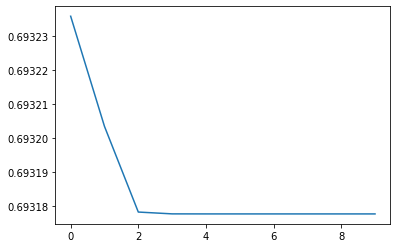

In [666]:
plt.plot(range(10), cost_list)
plt.show()

上を参考にクラス化する

In [678]:
class ScratchCNNClassifier:
    def __init__(self, lr, minibatch_size, filter_n, filter_w, filter_c,
                 n_nodes, sigma):
        self.lr = lr
        self.minibatch_size = minibatch_size
        self.n_nodes = n_nodes
        
        #filter数
        self.filter_n = filter_n
        #filter
        self.filter_w = filter_w
        #filter ch数
        self.filter_c = filter_c
        
        self.sigma = sigma
    
    def fit(self,X,y,epoch):
        
        self.n_features = X.shape[1]
        self.n_output = y.shape[1]
        
        self.w = np.ones((self.filter_n, self.filter_c, self.filter_w)).astype(np.float)
        self.b = np.ones(self.filter_n).astype(np.float)
        
        optimizer = SGD(self.lr)
        self.Conv = Conv1d(self.w, self.b, optimizer)
        self.activation1 = ReLU()
        self.FC2 = FC(self.filter_w, self.n_nodes, XavierInitializer(), optimizer)
        self.activation2 = ReLU()
        self.FC3 = FC(self.n_nodes, self.n_output, XavierInitializer(), optimizer)
        self.activation3 = Softmax()
        
        self.cost_list = []
        for i in range(epoch):
            get_mini_batch = GetMiniBatch(X, y, self.minibatch_size)
            for mini_X, mini_y in get_mini_batch:
                A1 = self.Conv.forward(mini_X)
                Z1 = self.activation1.forward(A1)
                A2 = self.FC2.forward(Z1)
                Z2 = self.activation2.forward(A2)
                A3 = self.FC3.forward(Z2)
                Z3 = self.activation3.forward(A3)

                #Loss Curvを描くための処理
            
                # 交差エントロピー誤差とソフトマックスを合わせている
                dA3, loss = self.activation3.backward(Z3, mini_y) 
                dZ2 = self.FC3.backward(dA3)                
                dA2 = self.activation2.backward(dZ2)
                dZ1 = self.FC2.backward(dA2)
                dA1 = self.activation1.backward(dZ1)
                dZ0 = self.Conv.backward(dA1) # dZ0は使用しない
            
            self.cost_list.append(np.mean(loss))
            
    def predict(self,X):
        A1 = self.Conv.forward(X)
        Z1 = self.activation1.forward(A1)
        A2 = self.FC2.forward(Z1)
        Z2 = self.activation2.forward(A2)
        A3 = self.FC3.forward(Z2)
        out = self.activation3.forward(A3)
        y = np.argmax(out, axis=1)
        
        return y

In [679]:
scnnc = ScratchCNNClassifier(lr=0.005, minibatch_size=50, filter_n=50, 
                             filter_c=1500, filter_w=50, n_nodes=30, sigma=0.01)

In [680]:
scnnc.fit(X_train, y_train_one_hot, 10)

C:\Users\Kei\anaconda3\envs\py_env\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log
C:\Users\Kei\anaconda3\envs\py_env\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in multiply


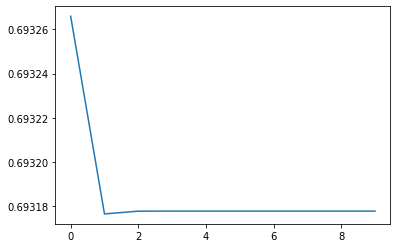

In [681]:
plt.plot(range(10), scnnc.cost_list)
plt.show()

MNISTを学習、推定

In [704]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [705]:
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

In [706]:
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

In [707]:
#訓練データと検証データに分割

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [708]:
#one-hot化

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)

y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_val_one_hot = enc.transform(y_val[:, np.newaxis])

In [687]:
scnnc2 = ScratchCNNClassifier(lr=0.005, minibatch_size=50, filter_n=50, 
                             filter_c=1500, filter_w=50, n_nodes=30, sigma=0.01)

In [688]:
scnnc2.fit(X_train, y_train_one_hot, 10)

C:\Users\Kei\anaconda3\envs\py_env\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log
C:\Users\Kei\anaconda3\envs\py_env\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in multiply


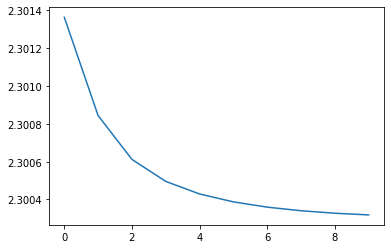

In [689]:
plt.plot(range(10), scnnc2.cost_list)
plt.show()

In [718]:
from sklearn.metrics import accuracy_score

score = []
get_mini_batch = GetMiniBatch(X_val, y_val, 50)
for mini_X, mini_y in get_mini_batch:
    y_mn_test_pred2 = scnnc2.predict(mini_X)
    score.append(accuracy_score(mini_y, y_mn_test_pred2))
    

In [723]:
np.mean(score)
print('Accuracy: ', np.mean(np.array(score)))

Accuracy:  0.11300000000000002
